In [1]:
import torch
import torchvision
from torchvision import transforms
from models import netD, netG
import numpy as np
from utils import gen_input, weights_init
import  matplotlib.pyplot as plt
from pytorch_msssim import ssim, ms_ssim

In [2]:
num_classes = 10
rand_size= 110

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

netG = netG(rand_size).to(device)
netD = netD().to(device)

optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0002)
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0002)

In [3]:
from train import load_checkpoint

netD, netG = load_checkpoint(netD,netG, checkpoint='checkpoint_60.pth', checkpoint_path= 'checkpoints_w/')

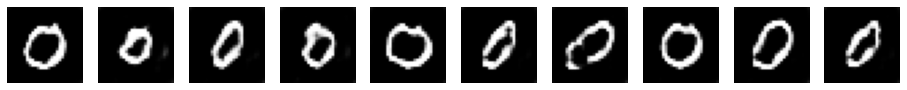

In [6]:
n_samples = 10
digit = 0

f, axes = plt.subplots(1,n_samples, figsize= (16,12))
for m in range(n_samples):
    noise = gen_input(digit, 1, num_classes, rand_size).cuda()
    fake_img = netG(noise).cpu().detach().numpy()
    axes[m].imshow(np.squeeze(fake_img), cmap= 'gray')
    axes[m].axis('off')

In [7]:
from torchvision.io import read_image
from torchvision.models import resnet18

model = resnet18(num_classes=10)
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.to(device)
model.eval()

model.load_state_dict(torch.load("resnet_checkpoint.pth"))

<All keys matched successfully>

In [17]:
noise = gen_input(0, 1000, num_classes, rand_size).to(device)
fake_img = netG(noise)
classes = model(transforms.Normalize((-1),(2))(fake_img))

best = torch.topk(classes,1,dim=1).indices.squeeze()
results = torch.eq(best, torch.zeros_like(best)).long()
print(round((torch.sum(results)/1000).item(),7))

0.9680001


In [18]:
ssim_val = 0
digit = 0

for i in range(1000):
  noise = gen_input(digit, 2, num_classes, rand_size).to(device)
  fake_img = netG(noise).cpu().detach()

  ssim_val += ssim(transforms.Normalize((-1),(2))(fake_img[0]).unsqueeze(0), transforms.Normalize((-1),(2))(fake_img[1]).unsqueeze(0), data_range=1, size_average=True, nonnegative_ssim=True)
  
print(f'SSIM: {ssim_val/1000}')

SSIM: 0.15070857107639313


In [23]:
ms_ssim_val = 0
digit = 0

for i in range(1000):
  noise = gen_input(digit, 2, num_classes, rand_size).to(device)
  fake_img = netG(noise).cpu().detach()
  fake_img=torchvision.transforms.Resize((162,162))(fake_img)
  ms_ssim_val += ms_ssim(transforms.Normalize((-1),(2))(fake_img[0]).unsqueeze(0), transforms.Normalize((-1),(2))(fake_img[1]).unsqueeze(0), data_range=1, size_average=True)
  
print(f'MS-SSIM: {ms_ssim_val/1000}')

MS-SSIM: 0.3004298806190491
